# Introducción

En este documento exploraremos y analizaremos un dataset proporcionado por el profesorado que imparte la asignatura _Aprendizaje Automático_ en la Facultad de Informática, Universidad Complutense de Madrid. 

Implementaremos un modelo que realice predicciones de etiquetado binario utilizando este dataset, considerando múltiples configuraciones para el modelo, observando cómo varía su precisión y eficiencia. Para llevar a cabo estas tareas, utilizaremos las librerías _matplotlib, numpy y scikit-learn_.

El objetivo de este ejercicio es, por lo tanto, poner en práctica varias habilidades aprendidas durante el desarrollo de la asignatura a lo largo de los últimos meses. Aun así, con el objetivo de enriquecer nuestra solución al problema, utilizaremos técnicas no vistas en la asignatura, como árboles de decisión.

El dataset con el que trabajaremos a lo largo del documento es [Tic-Tac-Toe Endgame](http://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (http://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame).

A continuación, realizaremos la carga de librerías, datos y un breve análisis.

In [1]:
# evita FutureWarning de keras
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import graphviz 
import pandas as pd

# sklearn
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score

# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model


# ficheros .py locales
from log_reg import LogReg # /log_reg.py
from neural_net import NeuralNet # /neural_net.py
from cross_validation import cv_config # /cross_validation
import drawing

Using TensorFlow backend.


In [2]:
!ls dataset/

tic-tac-toe.data  tic-tac-toe.names  tic-tac-toe_X.csv	tic-tac-toe_y.csv


In [3]:
df = pd.read_csv('dataset/tic-tac-toe.data', header=None)

print(f'number of instances:{df.shape[0]}, number of attributes:{df.shape[1]}')

number of instances:958, number of attributes:10


In [4]:
df.columns= ['p'+str(i) for i in range(0,df.shape[1]-1)] + ['y']

In [5]:
df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,y
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [6]:
df.describe()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,y
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


El dataset expone por cada tupla el contenido de las 9 posiciones del tablero de tres en raya, donde juegan dos jugadores denotados por *x* y *o*, así como la resolución de la partida, denotada con la cadena *positive* si ha ganado *x* o *negative* si ha ganado *o*. Por lo tanto, tenemos dos posibles etiquetas.

Leyendo el fichero _tic-tact-toe.names_ podemos conocer brevemente cómo se exponen los valores de las variables del dataset, concluyendo que en cada posición del tablero encontraremos una de tres opciones:

   > (x=player x has taken, o=player o has taken, b=blank)
    
Además, es relevante remarcar que se asume que el jugador *x* juega primero.

Cargamos los datos contenidos en el Dataframe *df* en arrays de Numpy para facilitar la manipulación de los datos en el código externo a este notebook.

In [7]:
feature_cols = df.columns[:-1]
label_cols = df.columns[-1]

In [8]:
X = np.asarray(df.loc[:, feature_cols])
y = np.asarray(df.loc[:, label_cols].ravel())
print(f'X.shape{X.shape}, y.shape{y.shape}')

X.shape(958, 9), y.shape(958,)


In [9]:
num_features = len(X[0])
num_labels = 2

Para reconocer mejor cómo se comportan los datos de *X* con respecto a sus etiquetas, *y*, dibujamos varios ejemplos en un tablero del juego *Tic tac toe*.

De esta forma, podemos conocer cómo se estructuran las variables características sobre el tablero y su relación con *y*, comprendiendo así mejor la naturaleza del problema.

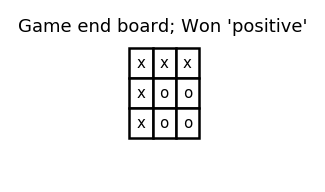

In [10]:
drawing.draw_end_game(X[0], y[0], categorical=True)

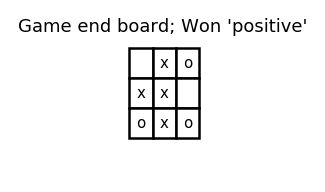

In [11]:
drawing.draw_end_game(X[500], y[500], categorical=True)

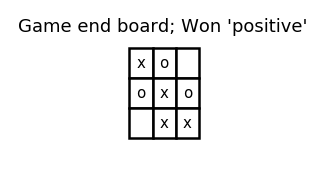

In [12]:
drawing.draw_end_game(X[210], y[210], categorical=True)

Observando estos ejemplos comprendemos que, efectivamente, al situarse en el tablero 3 fichas 'x' consecutivas en fila, columna o diagonal, se considera como ganador al jugador 'x'. En caso contrario, podemos afirmar que el ganador será 'o', ya que si el juego no llega a su fin por la victoria de 'x', llega a su fin por la victoria de 'o', no hay posibles empates. Este hecho encaja completamente con la naturaleza de las etiquetas *y*, ya que designan si ganó 'x' u 'o', no deja la posibilidad a empate.

Anticipando el análisis que llevaremos a cabo posteriormente, podemos preveer que no hay correlación entre los datos de X. Es decir, una configuración final de una partida de Tic-Tac-Toe y su resultado no guardan relación con otras configuraciones y otros resultados. De esta forma, analizando la distribución de los datos, es posible creer que construir correlaciones entre posiciones del tablero y los resultados finales (variables características y sus consecuentes etiquetas) es muy complejo por los medios que hemos estudiado en la asignatura. 

Los métodos utilizados a lo largo del curso para realizar predicción de clases han sido regresión logística, redes neuronales y support vector machines. De este conjunto de metodologías, las dos primeras construyen a lo largo del entrenamiento de sus modelos rectas o planos de decisión en base a la categorización de ejemplos vistos previamente. 

Este planteamiento colisiona, por la algoritmia utilizada hasta ahora, con la distribución de nuestros datos, ya que las variables características expresan presencia u ausencia de un jugador u otro en posiciones del tablero, las cuales no tienen una semántica relevante en el problema. Es decir, la existencia de una pieza del jugador 'x' en la posición 1,1 puede ser igual de relevante o irrelevante que si la pieza estuviera en la posicion 3,3, por ejemplo, a la hora de ganar una partida. No hay ninguna posición en el tablero que otorge una ventaja, todas las posiciones son igualmente accesibles en cualquier momento de la partida y por cualquier jugador. Esto ocurre al contrario en otros juegos de tablero como, por ejemplo, el ajedrez, juego en el cual posicionar una pieza en una posición concreta del tablero implica haber realizado cierto número de movimientos hasta llevar a la pieza a esa posición. Además, en el ajedrez, la funcionalidad (movimiento) de cada pieza puede verse afectada por su posición. Una torre situada en una esquina solo podrá ejecutar la mitad de sus posibles movimientos. 

En el caso del Tic-Tac-Toe, ninguna de estas implicaciones por la distribución de las piezas puede ser llevada a cabo, por lo tanto, preveemos que los modelos de regresión logística y red neuronal no serán capaces de adaptarse a los datos, no podrán construir una conclusión de los datos.

En cambio, los modelos support vector machine son mucho más sofisticados y complejos que regresión logística y red neuronal, por lo tanto, creemos que podrían responder mejor a la distribución de nuestros datos.

# Preprocesamiento

Para facilitar la manipulación de los datos tanto de *X* como de *y*, vamos a convertir el contenido de ambos arrays de datos categóricos a datos númericos.

Para ello, vamos a realizar el siguiente mapeo:

- **y** : lo mapearemos correspondientemente dos veces, inicialmente pasará a ser 'x'(positive) u 'o'(negative), después lo convertiremos a '1'(x) o '0'(o). Es decir, guardaremos de *y* sus datos categóricos y sus datos numéricos, permitiendo así posteriores análisis más cómodos.
- **X** : ya que los datos iniciales ya contenían 'x' u 'o', solo realizaremos la conversión a '1'(x) o '0'(o). Mantendremos ambas versiones de *X*, al igual que hacíamos con *y*.

Consideraremos de ahora en adelante: 0-->'o', 1-->'x', 2-->'b', tanto para *X* como para *y*, aunque *y* no tenga la etiqueta 'b'.

Para este proceso, definiremos dos funciones que nos ayudarán en las conversiones:

In [13]:
convert_to_nums = lambda x : 1 if x == 'x' else (0 if x == 'o' else 2)
convert_to_nums = np.vectorize(convert_to_nums)

convert_to_cats = lambda x : 'x' if x == 1 else ('o' if x == 0 else 'b')
convert_to_cats = np.vectorize(convert_to_cats)

In [14]:
X_cat = X # inicialmente X ya esta en version categorica

In [15]:
X = convert_to_nums(X_cat)
print(X[0], f'X.shape:{X.shape}')

[1 1 1 1 0 0 1 0 0] X.shape:(958, 9)


Una vez convertida cada variable categórica en una variable numérica, producimos tres variables numéricas _dummy_ por cada variable numérica actual.

Cada posición del tablero quedará designada por tres variables numéricas que expongan los siguientes escenarios, según lo que se encuentre en el ejemplo en la posición concreta del tablero:
- [1,0,0] es 'o'
- [0,1,0] es 'x'
- [0,0,1] es 'b'

In [16]:
onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3,4,5,6,7,8])
X = onehotencoder.fit_transform(X).toarray()

In [17]:
print(X[500], f'X.shape:{X.shape}')

[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0.] X.shape:(958, 27)


A continuación, eliminamos todas las terceras columnas ya que es información redudante. Con solo 2 columnas por posición del tablero podemos representar las tres posibilidades de la siguiente forma: 
- x:'10' 
- o:'00'
- b:'01'

Por lo tanto, utilizamos dos columnas como si fueran dos bits, representando las posibilidades de cada posición en base a combinaciones de bits.

De esta forma, reducimos las dimensiones del dataset y, además, evitamos el fenómeno conocido como _dummy variable trap_. Las variables _dummy_ son las variables que hemos construido hasta ahora para resolver el problema, son variables que toman un valor 1 o 0 denotando la presencia o ausencia de una característica o categoría. En este caso, el escenario _dummy variable trap_ se encuentra y entiende por la correlación múltiple entre las variables que utilizamos para designar cada posición del tablero. 

In [18]:
X = np.delete(X, [0,3,6,9,12,15,18,21,24], axis=1)

In [19]:
print(X[500], f'X.shape:{X.shape}')

[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.] X.shape:(958, 18)


Si interpretramos la transformación por el ejemplo *X[0]* podremos ver que es correcta al comparar el resultado con el tablero dibujado previamente sobre el mismo ejemplo. Actualizamos *num_features* para que se mantenga coherente.

In [20]:
num_features = len(X[0])

Realizamos un proceso muy similar con *y* en la conversión a _target_ numérico, a excepción de una interpretación previa en base al etiquetado 'positive' o 'negative. Esta interpretación solo la haremos una vez, por ello no guardamos la función que lo implementa. 

El valor de *y* 1 denota que la tupla de datos correspondiente pertenece a la clase "ha ganado x" mientras que su valor 0 denota que pertenece a la clase "no ha ganado X", lo cual es equivalente a "ha ganado o" ya que debe haber ganado uno de los dos jugadores, no hay posibilidad de empate.

In [21]:
y_cat = np.vectorize(lambda x: 'x' if x == 'positive' else 'o')(y)

In [22]:
y = convert_to_nums(y_cat)
print(y[0], f'y.shape:{y.shape}')

1 y.shape:(958,)


A continuación, probaremos diferentes tipos de modelos de predicción binaria para posteriormente realizar una comparación y conocer qué metodología de machine learning y con qué configuración ofrece mejores resultados para nuestro problema.

La implementación de los modelos basados en regresión logística y red neuronal de una capa oculta se encuentra en los ficheros `/log_reg.py` y `neural_net.py`. Estos ficheros exponen los modelos a través de clases cuyo objetivo es proporcionar al exterior una manipulación similar a la que exponen librerías como *scikit-learn*. El código de estos ficheros ha sido recogido de nuestras soluciones a las prácticas desarrolladas a lo largo del curso, con las modificaciones necesarias aplicadas para ser expuesto a través de clases.

Además, basándose en la teoría vista en clase y en la red neuronal de una capa oculta implementada en la práctica 4, el fichero `/multilayer_neural_net.py` implementa una red neuronal de n capas ocultas en una clase, similar a los modelos comentados previamente. Hemos decidido utilizar aun así en este notebook solamente la red neuronal de una capa oculta.

Creemos que encapsular los modelos en clases de esta forma facilita la manipulación de los mismos y permite una lectura de este documento más clara y sencilla. Por ello, no accederemos a métodos privados de las clases, utilizaremos accesos como `fit()`, `predict()`, etc, como si estuviéramos tratando con un modelo implementado en una librería.

Guardamos X e y en local para ahorrar el cómputo utilizado en el preprocesamiento para futuras cargas del notebook.

In [23]:
np.savetxt("dataset/tic-tac-toe_X.csv", X, delimiter=",")
np.savetxt("dataset/tic-tac-toe_y.csv", y, delimiter=",")

Dividimos nuestro conjunto de datos en el 60% para dedicarlos al entrenamiento de los modelos, en el 20% para dedicarlos a validación y en el 20% para dedicarlos a la evaluación de nuestros modelos. De esta forma, podemos conocer cómo responden nuestros modelos con datos nuevos, diferentes a los utilizados en el entrenamiento. La selección de qué datos pertenecerán a qué conjunto se realiza al azar con un *seed=42*.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, test_size=0.25, random_state=42)

In [25]:
print(f'X_train.shape:{X_train.shape},X_val.shape:{X_val.shape},X_test.shape:{X_test.shape}')

X_train.shape:(574, 18),X_val.shape:(192, 18),X_test.shape:(192, 18)


# Regresión logística

Inicialmente probaremos con regresión logística sin regularización. Por lo tanto, en el constructor del modelo definimos `reg_term=0`.

In [26]:
logreg = LogReg(num_features=num_features,
                num_labels=num_labels,reg_term=0)

In [27]:
logreg.fit(X=X_train, y=y_train)

num_func_eval:50


In [28]:
y_pred = logreg.predict(X=X_test)

In [29]:
print(f'logreg accuracy:{logreg.accuracy_score(y_test,y_pred)}%')

logreg accuracy:65.10416666666666%


Como preveíamos anteriormente, el modelo de regresión logística no es capaz de obtener una conclusión de los datos de entrenamiento. A continuación construiremos y entrenaremos otro modelo utilizando regularización.

In [30]:
logreg = LogReg(num_features=num_features,
                num_labels=num_labels,reg_term=1.5)

In [31]:
logreg.fit(X=X_train, y=y_train)

num_func_eval:50


In [32]:
y_pred = logreg.predict(X=X_test)

In [33]:
print(f'logreg accuracy:{logreg.accuracy_score(y_test,y_pred)}%')

logreg accuracy:65.10416666666666%


In [34]:
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


Observando las etiquetas que ha predecido el modelo sobre datos nuevos podemos comprobar que siempre predice la misma clase. En este caso, siempre predice la clase 1, es decir, que gana el jugador 'x'. Por lo tanto, el 65.104% de acierto del modelo se debe a que el conjunto de datos contiene ese porcentaje de partidas etiquetadas por la clase 1.

Agregar términos polinómicos al conjunto de datos no debe ser solución la problemática que encuentra la regresión logística con los datos debido a la representación de las variables características a través de *one-hot encoding*. Aun así, probamos con un grado 4.

In [35]:
poly = PolynomialFeatures(4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
num_features_poly = len(X_train_poly[0])
print(f'X_train_poly.shape:{X_train_poly.shape}')

X_train_poly.shape:(574, 7315)


In [36]:
logreg = LogReg(num_features=num_features_poly,
                num_labels=num_labels,reg_term=1.5)

In [37]:
logreg.fit(X=X_train_poly, y=y_train)

num_func_eval:54


In [38]:
y_pred = logreg.predict(X=X_test_poly)

In [39]:
print(f'logreg accuracy:{logreg.accuracy_score(y_test,y_pred)}%')

logreg accuracy:65.10416666666666%


El resultado es el mismo que hemos obtenido previamente.

A continuación, probaremos la regresión logística implementada por la librería *sklearn*.

In [40]:
logreg = LogisticRegression(random_state=0)

In [41]:
logreg.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
print(f'logreg accuracy:{logreg.score(X_test, y_test)*100}%')

logreg accuracy:78.64583333333334%


Observamos que esta vez, utilizando este modelo, sin ninguna hiper parametrización, el resultado es correcto, a pesar de ser muy bajo. Esto se debe a que la librería *sklearn* utiliza otros algoritmos de optimización más sofisticados que le permiten al modelo adaptarse mejor a la naturaleza del problema. En concreto, por default, el modelo utilizará *liblinear*, el cual funciona correctamente en conjuntos de datos pequeños.

Con el objetivo de mejorar el resultado obtenido y teniendo en mente que *sklearn* nos permite elegir el algoritmo de optimización a utilizar, probaremos dos posibilidades más.

Primero, probaremos utilizando el algoritmo *newton-cg*:

In [43]:
logreg = LogisticRegression(random_state=0,
                            solver='newton-cg', multi_class='multinomial')

In [44]:
logreg.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
print(f'logreg accuracy:{logreg.score(X_test, y_test)*100}%')

logreg accuracy:94.79166666666666%


Para el mismo algoritmo de optimización, probaremos a cambiar el parámetro *C*, cuyo valor por default es 1.

In [46]:
logreg = LogisticRegression(random_state=0,
                            solver='newton-cg', multi_class='multinomial', C=1.5)

In [47]:
logreg.fit(X=X_train, y=y_train)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
print(f'logreg accuracy:{logreg.score(X_test, y_test)*100}%')

logreg accuracy:96.875%


Observamos que el porcentaje de acierto ha subido considerablemente al cambiar el algoritmo de optimización y, en menor medida, también al cambiar el parámetro *C*, el cual denota una menor regularización. Esto quiere decir que hemos reducido el sesgo del modelo, balanceándolo.

In [49]:
logreg = LogisticRegression(random_state=0,
                            solver='newton-cg', multi_class='multinomial', C=2.0)

In [50]:
logreg.fit(X=X_train, y=y_train)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
print(f'logreg accuracy:{logreg.score(X_test, y_test)*100}%')

logreg accuracy:96.875%


Aumentando el parámetro *C* no conseguimos mejores resultados,por lo tanto, pasamos a comprobar qué resultados nos da el siguiente algoritmo de optimización, *lbfgs*.

In [52]:
logreg = LogisticRegression(random_state=0,
                            solver='lbfgs', multi_class='multinomial', C=2.0)

In [53]:
logreg.fit(X=X_train, y=y_train)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
print(f'logreg accuracy:{logreg.score(X_test, y_test)*100}%')

logreg accuracy:96.875%


No encontramos mejoría con este algoritmo de optimización.

Por lo tanto, avanzamos al siguiente apartado.

# Red Neuronal

En este apartado construiremos, inicialmente, una red neuronal con una capa oculta y probaremos diferentes configuraciones.

In [55]:
num_hidden_nodes = 9

In [56]:
nnet = NeuralNet(num_features=num_features,
                 num_hidden_nodes=num_hidden_nodes, num_labels=2, reg_term=0)

In [57]:
nnet.fit(X=X_train, y=y_train)

In [58]:
y_pred = nnet.predict(X=X_test)

In [59]:
print(f'neuralnet accuracy:{nnet.accuracy_score(y_test,y_pred)}%')

neuralnet accuracy:34.89583333333333%


In [60]:
print(y_pred) # siempre predice la misma clase

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


El resultado es el mismo que hemos obtenido inicialmente con regresión logística ocurriendo lo mismo que ocurría anteriormente: el modelo siempre predice la misma clase.

Esta causalidad se debe a la implementación algorítmica utilizada tanto en regresión logística como en redes neuronales a lo largo de las prácticas de la asignatura. En las prácticas resueltas en el curso estos algoritmos respondieron como se esperaba de ellos. En cambio, en su uso en la resolución del problema que propone este dataset, no son capaces de construir hipótesis válidas.

Probamos a construir una red neuronal con más nodos en la capa oculta con el objetivo de otorgarle al modelo la fuerza suficiente para poder adaptarse a los datos. Para compensar la cantidad de nodos creciente, agregamos regularización para evitar *overfitting*.

In [61]:
num_hidden_nodes = 27

In [62]:
nnet = NeuralNet(num_features=num_features,
                 num_hidden_nodes=num_hidden_nodes, num_labels=2, reg_term=0.5)

In [63]:
nnet.fit(X=X_train, y=y_train)

In [64]:
y_pred = nnet.predict(X=X_test)

In [65]:
print(f'neuralnet accuracy:{nnet.accuracy_score(y_test,y_pred)}%')

neuralnet accuracy:34.89583333333333%


In [66]:
num_hidden_nodes = 36

In [67]:
nnet = NeuralNet(num_features=num_features,
                 num_hidden_nodes=num_hidden_nodes, num_labels=2, reg_term=1.2)

In [68]:
nnet.fit(X=X_train, y=y_train)

In [69]:
y_pred = nnet.predict(X=X_test)

In [70]:
print(f'neuralnet accuracy:{nnet.accuracy_score(y_test,y_pred)}%')

neuralnet accuracy:65.10416666666666%


El resultado, de nuevo, no es satisfactorio, por lo explicado anteriormente.

Las redes neuronales que hemos construido hasta ahora no son suficientemente potentes para responder a la distribución de nuestros datos, donde cada ejemplos es independiente del resto y no existe un correlación entre ellos como ocurría en otros problemas tratados en la asignatura. 

Por ello, para lograr generalizar, necesitaremos construir un modelo más sofisticado.
Para esta tarea utilizaremos la librería *keras*, la cual nos permitirá construir una red neuronal más compleja con más capas y otros algoritmos de optimización.

## Keras

Inicializamos la red neuronal como una secuencia lineal de capas construida tal y como hemos estudiado en la asignatura.

In [71]:
nnet = Sequential()

A continuación agregamos las siguientes capas:
- **1ª capa oculta:** dado que el número de variables características de X tras el preprocesamiento es 18, la dimensión de entrada de esta capa debe ser 18 también. La cantidad de nodos de la capa es 9 como resultado de redondear la suma de la cantidad de variables características con la cantidad de clases a predecir entre 2. Utiliza como función de activación *ReLU (Rectified Linear Unit)* debido a su popularidad en construcciones similares a esta.
- **2ª capa oculta:** su dimensión de entrada debe ser 9 debido a que es la dimensión de salida de la capa anterior. Además, su cantidad de nodos, seguirá el mismo razonamiento que la dimensión de salida de la capa 1ª, así como su función de activación.
- **Capa salida:** su dimensión de entrada debe ser 9 debido a que es la dimensión de salida de la capa anterior. Su dimensión de salida será igual a la cantidad de clases a predecir. Tenemos 2 clases pero la predicción de una puede ser deducida por la predicción de la otra. Es decir, con una única unidad en la capa de salida es suficiente. Utiliza como función de activación *sigmoid* porque esta se mueve en el intervalo [0,1] y, por lo tanto, es ideal para dar el output final de la red como probabilidad en [0,1].

La función *relu* cumple la siguiente expresión:

$$ R(z) = max(0,z) $$

La función *sigmoid* cumple con la siguiente expresión:

$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

In [72]:
nnet.add(Dense(units=9, kernel_initializer='uniform', activation='relu', input_dim=18))

nnet.add(Dense(units=9, kernel_initializer='uniform', activation='relu'))

nnet.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

Compilamos la red para configurar la red con las capas definidas previamente.

Utilizamos el optimizer *Adam* debido a su bajo coste computacional y su leve carga en memoria, lo cual agiliza el entrenamiento y, como consecuencia, la posterior prueba de diferentes configuraciones. Su funcionamiento dista en cuanto al optimizer visto en la asignatura, *gradient descent*, en el trato del parámetro *learning rate* en el entrenamiento. En vez de utilizar el mismo *learning rate* a lo largo de todo el entrenamiento como hemos aprendido al desarrollar *gradient descent*, combina el planteamiento de las técnicas *Adaptive Gradient Algorithm (AdaGrad)* y *Root Mean Square Propagation (RMSProp)*. *Adam* fue propuesto por Diederik Kingma y Jimmy Ba de la Universidad de Toronto en un paper titulado [“Adam: A Method for Stochastic Optimization“](https://arxiv.org/abs/1412.6980) en ICLR, 2015. 

Para la decisión del optimizer a utilizar nos hemos apoyado, además, en un paper desarrollado por Sebastian Ruder y titulado ["An overview of gradient descent optimization algorithms"](https://arxiv.org/abs/1609.04747)

La función de coste es *binary_crossentropy* debido a que la última capa utiliza *sigmoid* como función de activación y debido a que la clasificación a realizar es binaria. Se corresponde con el planteamiento que hemos utilizado en la asignatura para la función de coste en redes neuronales.

In [73]:
nnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [75]:
plot_model(nnet, to_file='nnet_plot.png', show_shapes=True, show_layer_names=True)

![Keras Neural Network Visualization](./nnet_plot.png)

Entrenamos la red considerando 150 *epochs*.

Utilizaremos el conjunto de datos de validación en el entrenamiento de la red con el objetivo de evitar overfitting y conseguir que nuestro modelo generalice mejor para ejemplos diferentes a los de entrenamiento.

In [76]:
num_epochs = 150

In [77]:
train_history = nnet.fit(X_train, y_train, batch_size=10,
                         epochs=num_epochs, validation_data=(X_val, y_val))

Train on 574 samples, validate on 192 samples
Epoch 1/150
574/574 [==============================] - 1s 1ms/step - loss: 0.6883 - acc: 0.6394 - val_loss: 0.6807 - val_acc: 0.6563
Epoch 2/150
574/574 [==============================] - 0s 299us/step - loss: 0.6647 - acc: 0.6533 - val_loss: 0.6458 - val_acc: 0.6563
Epoch 3/150
574/574 [==============================] - 0s 378us/step - loss: 0.6307 - acc: 0.6533 - val_loss: 0.6236 - val_acc: 0.6563
Epoch 4/150
574/574 [==============================] - 0s 273us/step - loss: 0.6179 - acc: 0.6533 - val_loss: 0.6152 - val_acc: 0.6563
Epoch 5/150
574/574 [==============================] - 0s 362us/step - loss: 0.6069 - acc: 0.6533 - val_loss: 0.6056 - val_acc: 0.6563
Epoch 6/150
574/574 [==============================] - 0s 339us/step - loss: 0.5937 - acc: 0.6603 - val_loss: 0.5952 - val_acc: 0.6667
Epoch 7/150
574/574 [==============================] - 0s 384us/step - loss: 0.5790 - acc: 0.6882 - val_loss: 0.5856 - val_acc: 0.7031
Epoch 8/150

Epoch 61/150
574/574 [==============================] - 0s 285us/step - loss: 0.4370 - acc: 0.7840 - val_loss: 0.4873 - val_acc: 0.7760
Epoch 62/150
574/574 [==============================] - 0s 208us/step - loss: 0.4287 - acc: 0.8014 - val_loss: 0.4834 - val_acc: 0.7604
Epoch 63/150
574/574 [==============================] - 0s 217us/step - loss: 0.4249 - acc: 0.7892 - val_loss: 0.4815 - val_acc: 0.7760
Epoch 64/150
574/574 [==============================] - 0s 243us/step - loss: 0.4206 - acc: 0.7979 - val_loss: 0.4744 - val_acc: 0.7604
Epoch 65/150
574/574 [==============================] - 0s 193us/step - loss: 0.4177 - acc: 0.8066 - val_loss: 0.4697 - val_acc: 0.7865
Epoch 66/150
574/574 [==============================] - 0s 232us/step - loss: 0.4133 - acc: 0.8118 - val_loss: 0.4699 - val_acc: 0.7812
Epoch 67/150
574/574 [==============================] - 0s 258us/step - loss: 0.4064 - acc: 0.8066 - val_loss: 0.4614 - val_acc: 0.7604
Epoch 68/150
574/574 [==========================

574/574 [==============================] - 0s 240us/step - loss: 0.1137 - acc: 0.9843 - val_loss: 0.1149 - val_acc: 0.9948
Epoch 122/150
574/574 [==============================] - 0s 283us/step - loss: 0.1133 - acc: 0.9861 - val_loss: 0.1153 - val_acc: 0.9948
Epoch 123/150
574/574 [==============================] - 0s 246us/step - loss: 0.1053 - acc: 0.9861 - val_loss: 0.1056 - val_acc: 0.9948
Epoch 124/150
574/574 [==============================] - 0s 223us/step - loss: 0.1040 - acc: 0.9861 - val_loss: 0.1012 - val_acc: 0.9948
Epoch 125/150
574/574 [==============================] - 0s 190us/step - loss: 0.1022 - acc: 0.9861 - val_loss: 0.1023 - val_acc: 0.9948
Epoch 126/150
574/574 [==============================] - 0s 257us/step - loss: 0.1030 - acc: 0.9878 - val_loss: 0.1013 - val_acc: 0.9948
Epoch 127/150
574/574 [==============================] - 0s 192us/step - loss: 0.0989 - acc: 0.9861 - val_loss: 0.0968 - val_acc: 0.9948
Epoch 128/150
574/574 [==============================] 

Para evaluar el resultado del entrenamiento del modelo, dibujamos la progresión de la precisión y del error de la red neuronal construida sobre los ejemplos de entrenamiento y sobre los ejemplos de validación. Esto nos permite reconocer posibles errores de bias u overfitting, si los hubiera.

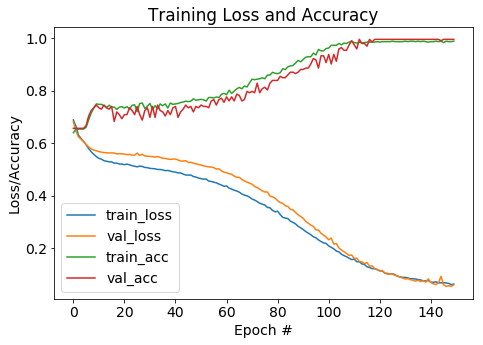

In [78]:
epochs_range = np.arange(0, num_epochs)

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(7.5,5))
plt.plot(epochs_range, train_history.history["loss"], label="train_loss")
plt.plot(epochs_range, train_history.history["val_loss"], label="val_loss")
plt.plot(epochs_range, train_history.history["acc"], label="train_acc")
plt.plot(epochs_range, train_history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Tanto el coste como la precisión de ambos conjuntos de ejemplos progresan de forma ideal. El coste desciende considerablemente a lo largo del entrenamiento así como la precisión aumenta, lo cual predice que la red funciona correctamente.

Una vez entrenada la red, predecimos el etiquetado de los datos de *X_test*

In [79]:
y_pred = nnet.predict_classes(X_test)

In [80]:
print(f'neuralnet accuracy:{accuracy_score(y_test,y_pred)*100}%')

neuralnet accuracy:97.91666666666666%


El resultado es bueno, alcanzando un porcentaje de acierto realmente correcto con un tiempo de entrenamiento muy breve.

Esto se debe a una correcta elección hiper paramétrica del modelo así como una construcción robusta de la red neuronal. Gracias a la librería *Keras* podemos utilizar estos ajustes en el modelo. De no ser así, tendríamos que cambiar en gran medida el compartamiento del modelo desarrollado a lo largo de las prácticas.

A continuación, probamos diferentes configuraciones de la red neuronal construida para intentar obtener un porcentaje de aciertos mayor.

In [81]:
nnet = Sequential()

nnet.add(Dense(units=9, kernel_initializer='uniform', activation='relu', input_dim=18))

nnet.add(Dense(units=9, kernel_initializer='uniform', activation='relu'))

nnet.add(Dense(units=9, kernel_initializer='uniform', activation='relu'))

nnet.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

nnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

En este caso, entrenamos la red con un número *epochs* mayor debido al aumento del número de capas ocultas.

In [82]:
num_epochs = 200

In [83]:
train_history = nnet.fit(X_train, y_train, batch_size=10,
                         epochs=num_epochs, validation_data=(X_val, y_val))

Train on 574 samples, validate on 192 samples
Epoch 1/200
574/574 [==============================] - 1s 1ms/step - loss: 0.6907 - acc: 0.6324 - val_loss: 0.6873 - val_acc: 0.6563
Epoch 2/200
574/574 [==============================] - 0s 313us/step - loss: 0.6833 - acc: 0.6533 - val_loss: 0.6773 - val_acc: 0.6563
Epoch 3/200
574/574 [==============================] - 0s 441us/step - loss: 0.6672 - acc: 0.6533 - val_loss: 0.6527 - val_acc: 0.6563
Epoch 4/200
574/574 [==============================] - 0s 324us/step - loss: 0.6426 - acc: 0.6533 - val_loss: 0.6326 - val_acc: 0.6563
Epoch 5/200
574/574 [==============================] - 0s 379us/step - loss: 0.6272 - acc: 0.6533 - val_loss: 0.6238 - val_acc: 0.6563
Epoch 6/200
574/574 [==============================] - 0s 370us/step - loss: 0.6199 - acc: 0.6533 - val_loss: 0.6194 - val_acc: 0.6563
Epoch 7/200
574/574 [==============================] - 0s 484us/step - loss: 0.6134 - acc: 0.6533 - val_loss: 0.6146 - val_acc: 0.6563
Epoch 8/200

Epoch 61/200
574/574 [==============================] - 0s 283us/step - loss: 0.4600 - acc: 0.7683 - val_loss: 0.4982 - val_acc: 0.7344
Epoch 62/200
574/574 [==============================] - 0s 284us/step - loss: 0.4529 - acc: 0.7787 - val_loss: 0.5042 - val_acc: 0.7708
Epoch 63/200
574/574 [==============================] - 0s 273us/step - loss: 0.4567 - acc: 0.7683 - val_loss: 0.5041 - val_acc: 0.7708
Epoch 64/200
574/574 [==============================] - 0s 229us/step - loss: 0.4517 - acc: 0.7666 - val_loss: 0.4899 - val_acc: 0.7396
Epoch 65/200
574/574 [==============================] - 0s 281us/step - loss: 0.4519 - acc: 0.7683 - val_loss: 0.4979 - val_acc: 0.7135
Epoch 66/200
574/574 [==============================] - 0s 269us/step - loss: 0.4438 - acc: 0.7875 - val_loss: 0.4983 - val_acc: 0.7135
Epoch 67/200
574/574 [==============================] - 0s 226us/step - loss: 0.4374 - acc: 0.7840 - val_loss: 0.4870 - val_acc: 0.7760
Epoch 68/200
574/574 [==========================

574/574 [==============================] - 0s 238us/step - loss: 0.0789 - acc: 0.9861 - val_loss: 0.1032 - val_acc: 0.9896
Epoch 122/200
574/574 [==============================] - 0s 261us/step - loss: 0.0951 - acc: 0.9861 - val_loss: 0.0783 - val_acc: 0.9896
Epoch 123/200
574/574 [==============================] - 0s 279us/step - loss: 0.0764 - acc: 0.9861 - val_loss: 0.0715 - val_acc: 0.9896
Epoch 124/200
574/574 [==============================] - 0s 260us/step - loss: 0.0745 - acc: 0.9861 - val_loss: 0.0788 - val_acc: 0.9896
Epoch 125/200
574/574 [==============================] - 0s 227us/step - loss: 0.0738 - acc: 0.9861 - val_loss: 0.0700 - val_acc: 0.9896
Epoch 126/200
574/574 [==============================] - 0s 306us/step - loss: 0.0734 - acc: 0.9861 - val_loss: 0.0685 - val_acc: 0.9896
Epoch 127/200
574/574 [==============================] - 0s 270us/step - loss: 0.0715 - acc: 0.9861 - val_loss: 0.0710 - val_acc: 0.9896
Epoch 128/200
574/574 [==============================] 

Epoch 181/200
574/574 [==============================] - 0s 277us/step - loss: 0.0569 - acc: 0.9843 - val_loss: 0.0552 - val_acc: 0.9896
Epoch 182/200
574/574 [==============================] - 0s 282us/step - loss: 0.0441 - acc: 0.9861 - val_loss: 0.0563 - val_acc: 0.9896
Epoch 183/200
574/574 [==============================] - 0s 226us/step - loss: 0.0464 - acc: 0.9878 - val_loss: 0.0741 - val_acc: 0.9896
Epoch 184/200
574/574 [==============================] - 0s 257us/step - loss: 0.0444 - acc: 0.9895 - val_loss: 0.0575 - val_acc: 0.9896
Epoch 185/200
574/574 [==============================] - 0s 249us/step - loss: 0.0445 - acc: 0.9913 - val_loss: 0.0584 - val_acc: 0.9896
Epoch 186/200
574/574 [==============================] - 0s 200us/step - loss: 0.0426 - acc: 0.9895 - val_loss: 0.0545 - val_acc: 0.9896
Epoch 187/200
574/574 [==============================] - 0s 291us/step - loss: 0.0443 - acc: 0.9878 - val_loss: 0.0616 - val_acc: 0.9844
Epoch 188/200
574/574 [==================

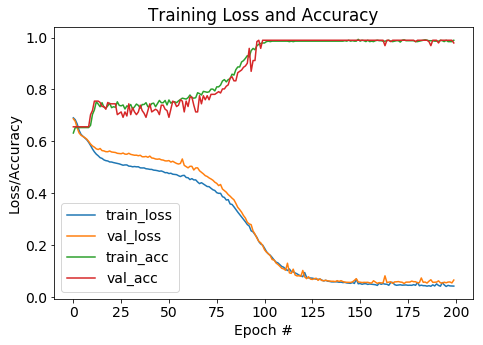

In [84]:
epochs_range = np.arange(0, num_epochs)

plt.figure(figsize=(7.5,5))
plt.plot(epochs_range, train_history.history["loss"], label="train_loss")
plt.plot(epochs_range, train_history.history["val_loss"], label="val_loss")
plt.plot(epochs_range, train_history.history["acc"], label="train_acc")
plt.plot(epochs_range, train_history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

El resultado del entrenamiento es realmente similar al obtenido previamente: exitoso.

In [85]:
y_pred = nnet.predict_classes(X_test)

In [86]:
print(f'neuralnet accuracy:{accuracy_score(y_test,y_pred)*100}%')

neuralnet accuracy:96.35416666666666%


El resultado es el mismo. Quiere decir que ya alcanzó una configuración óptima el modelo con la construcción anterior.

Por lo tanto, consideramos que no podemos obtener mejores resultados agregando más capas aún a la red.

# Support Vector Machines

Definimos los parámetros que vamos a utilizar inicialmente para la construcción del modelo.

In [87]:
C, sigma = 2.0, 1.0
gamma = lambda s: 1/(2*s**2)

In [88]:
svm = SVC(kernel='rbf', C=C, gamma=gamma(sigma))

In [89]:
svm.fit(X=X_train,y=y_train)

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
y_pred = svm.predict(X=X_test)

In [91]:
print(f'svm accuracy:{accuracy_score(y_test,y_pred)*100}%')

svm accuracy:95.83333333333334%


## Cross-Validation

Probaremos varias configuraciones de parámetros C y sigma a través del método cv_config() que prueba combinaciones de diferentes C con diferentes sigma utilizando la metodología de validación vista en la asignatura. Para ello, utiliza los datos de entrenamiento y los datos de validación.

In [92]:
svm = SVC(kernel='rbf') # modelo vacio
scores, configs = cv_config(svm, train_X=X_train,
                            train_y=y_train, val_X=X_val, val_y=y_val)
best_config_index = np.argmax(scores)
best_C = configs[best_config_index][0]
best_sigma = configs[best_config_index][1]
print(f'best score:{scores[best_config_index]*100}%,'
      +f' config:(C={best_C},'
      +f'sigma={best_sigma})')

best score:98.95833333333334%, config:(C=10.0,sigma=3.0)


Una vez conocemos los mejores parámetros posibles para el modelo, los utilizamos para conocer qué porcentaje de acierto obtenemos sobre el conjunto de datos *X_test*.

In [93]:
svm = SVC(kernel='rbf', C=best_C, gamma=gamma(best_sigma))

In [94]:
svm.fit(X=X_train,y=y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05555555555555555,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [95]:
y_pred = svm.predict(X=X_test)

In [96]:
print(f'svm accuracy:{accuracy_score(y_test,y_pred)*100}%')

svm accuracy:96.875%


El resultado es muy bueno, es el mismo que obteníamos previamente con la red construida con *Keras*.

# Árboles de decisión

Debido a la naturaleza de este problema y la distribución de sus datos, creemos que un modelo basado en árboles de decisión podría determinar resultados interesantes, por lo tanto, utilizando la librería sklearn de nuevo, construiremos un árbol de decisión a continuación.

In [97]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=None,max_leaf_nodes=None)

In [98]:
dtree.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [99]:
print(f'decission tree accuracy:{dtree.score(X_test, y_test)*100}%')

decission tree accuracy:89.0625%


In [100]:
dtree = DecisionTreeClassifier(criterion = "entropy", random_state = 42,
 max_depth=3, min_samples_leaf=5)

In [101]:
dtree.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [102]:
print(f'decission tree accuracy:{dtree.score(X_test, y_test)*100}%')

decission tree accuracy:69.27083333333334%


Resultado muy pobre comparado con el resultado anterior con la hiper parametrización inicial.

In [106]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=10,max_leaf_nodes=None)

In [107]:
dtree.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [108]:
print(f'decission tree accuracy:{dtree.score(X_test, y_test)*100}%')

decission tree accuracy:88.02083333333334%


Obtenemos el mismo resultado prácticamente que hemos obtenido al inicio del análisis con árboles de decisión. 

Por lo tanto, pasamos a visualizar el último árbol de decisión construido.

## Visualización 

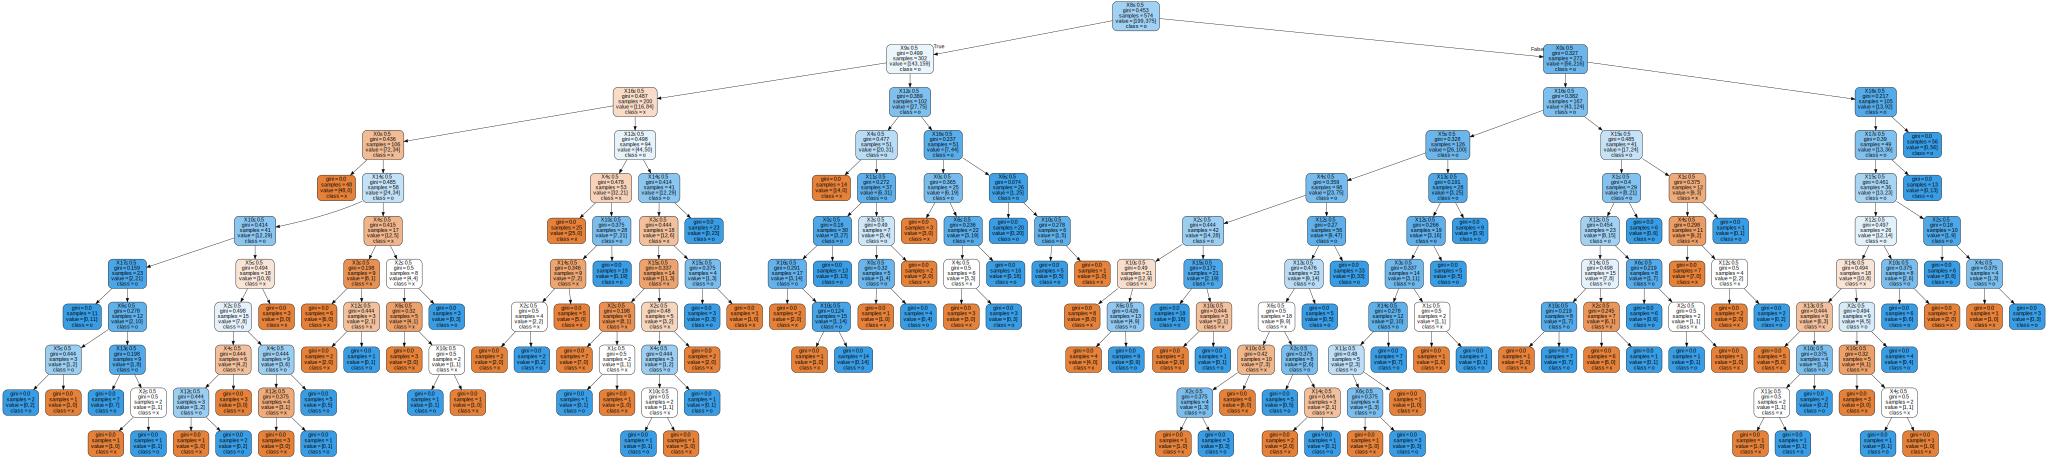

In [110]:
dot_data = export_graphviz(dtree, out_file=None, class_names=['x','o'],
                           filled=True, rounded=True,
                           special_characters=True)  
graph = graphviz.Source(dot_data)
graph

# Conclusión

Una vez desarrollados y analizados múltiples modelos de aprendizaje automático sobre los datos del problema _Tic-Tac-Toe Endgame_, podemos concluir que los mejores resultados han sido alcanzados con las siguientes configuraciones:
- Regresión logística por sci-kit learn con algoritmo de optimización lbfgs,newton-cg y C=2.
- Red neuronal por keras con algoritmo de optimización Adam y dos capas intermedias con 9 nodos cada una.
- Support Vector Machine con C=10 y sigma=3.
- Árboles de decisión con criterio de split gini, sin límite de profundidad del árbol ni límite del número de nodos.

Los modelos construidos con estas configuraciones han sido capaces de alcanzar tasas de acierto sobre ejemplos diferentes a los de entrenamiento de 96-98%. Consideramos este resultado realmente satisfactorio. 


Desarrollar este problema nos ha concedido varias nociones sobre el aprendizaje automático debido a la resolución de las dificultades que hemos encontrado a la hora de construir modelos que pudieran adaptarse correctamente al problema. Las metodologías utilizadas, sobre todo aquellas innovadoras con respecto al contexto de la asignatura, han enriquecido en gran medida nuestro conocimiento sobre resolución de problemas de clasificación.


Es relevante señalar las siguientes publicaciones, las cuales han sido de gran ayuda a lo largo del desarrollo de este documento:
- Saher Esmeir and Shaul Markovitch. "Lookahead-based algorithms for anytime induction of decision trees", ICML. 2004 : http://rexa.info/paper/ff82c050c05e8845f7a81bb4e723cf41fbd2efec
- Jinyan Li and Kotagiri Ramamohanarao and Guozhu Dong. "Combining the Strength of Pattern Frequency and Distance for Classification", PAKDD. 2001 : http://rexa.info/paper/0cedee7ef9325127fb946dcdddf8795644e28335
- David R Musicant. "DATA MINING VIA MATHEMATICAL PROGRAMMING AND MACHINE LEARNING", Doctor of Philosophy (Computer Sciences) UNIVERSITY : http://rexa.info/paper/f1395e1da4a724219d6cc414e48969140355bebb